<a href="https://colab.research.google.com/github/mouhsineguet/Data-Science-portfolio/blob/main/fire_incendies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import the package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, validation_curve,learning_curve,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2,f_classif, SelectKBest
from imblearn.over_sampling import ADASYN, SMOTEN
from xgboost import XGBClassifier as xgb
import sklearn.metrics as mt
from itertools import cycle

In [ ]:
#import the dataset
data=pd.read_csv('dataf.csv')
data.head(15)

,temp,pression,hum,CO,CO2,PM2.5,PM10,feu
0,10.04,944.088127,100.000000,0.5,516.307821,2.5,5.3,0
1,11.67,941.739694,100.000000,0.5,445.129147,3.3,9.2,0
2,17.20,943.379724,74.267170,0.5,407.660475,0.8,2.5,0
3,11.62,942.064535,100.000000,0.5,462.124815,3.0,9.2,0
4,12.59,932.754939,100.000000,0.5,487.964621,7.0,20.9,0
5,12.46,945.680794,100.000000,0.5,509.113541,2.3,4.7,0
6,9.47,941.953570,100.000000,0.5,497.634878,7.6,9.7,0
7,17.98,933.156037,65.719738,13.4,540.380945,17.2,46.5,1
8,9.84,941.522340,100.000000,0.5,507.733097,3.8,5.4,0
9,9.06,941.054708,100.000000,0.5,497.789850,4.6,6.3,0


In [ ]:
#statistic dist
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,5528.0,15.905478,6.697769,8.630000,11.170000,13.360000,18.770000,43.810000
pression,5528.0,941.746778,2.703559,932.382771,940.583288,941.806903,943.557098,946.048143
hum,5528.0,78.006057,26.820208,17.165410,52.381195,100.000000,100.000000,100.000000
CO,5528.0,3.220894,23.779772,0.500000,0.500000,0.500000,0.500000,309.100000
CO2,5528.0,474.602901,161.977301,397.527685,413.685014,472.035279,498.654714,2642.306557
PM2.5,5528.0,18.788386,120.492720,0.600000,2.500000,3.300000,4.000000,999.900000
PM10,5528.0,36.497287,227.917943,1.200000,5.300000,8.100000,9.800000,1999.900000
feu,5528.0,0.037988,0.191186,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
#test the null val
data.isnull().sum()
### so we do not have missing values Great

temp        0
pression    0
hum         0
CO          0
CO2         0
PM2.5       0
PM10        0
feu         0
dtype: int64

In [ ]:
### checking the deplucate values
data.duplicated().sum()
### nice we do not have duplicated data 

0

In [ ]:
## print col names
data.columns

Index(['temp', 'pression', 'hum', 'CO', 'CO2', 'PM2.5', 'PM10', 'feu'], dtype='object')

In [ ]:
### check the is data is balanced or not 
fire_percentage=data["feu"].value_counts(0)
fire_percentage/len(data)

0    0.962012
1    0.037988
Name: feu, dtype: float64

In [ ]:
### Emmmm it looks that the data is truely imbalancede we should balanced it 
print('the case of not fire we have 96% of the data and 0.4% in the case of fire' )

the case of not fire we have 96% of the data and 0.4% in the case of fire


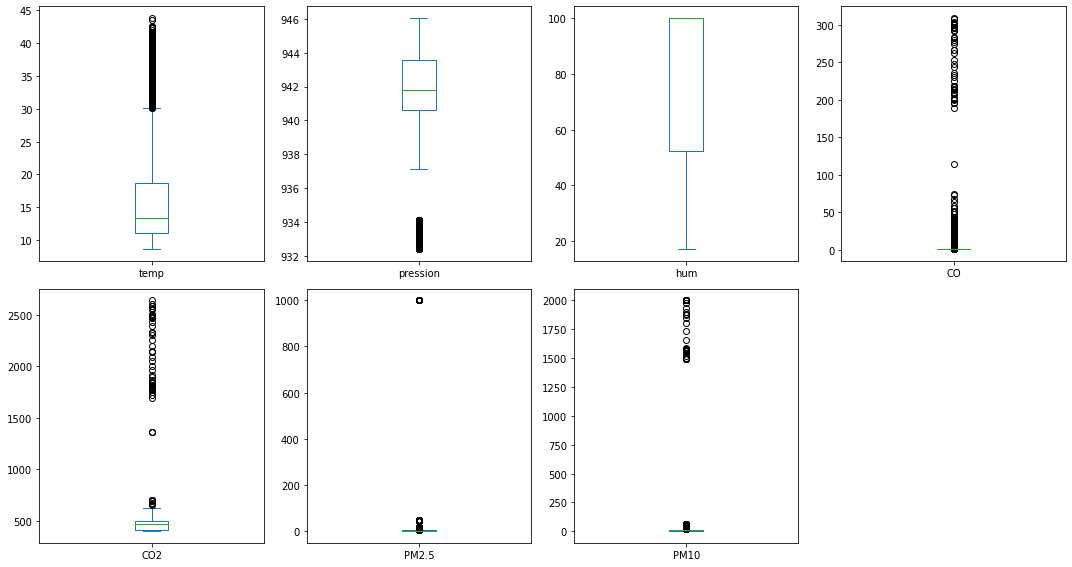

In [ ]:
### checking the outlires 
X_col=data.drop(["feu"], axis=1).columns
plt.figure(figsize=(15,8))
for i,col in enumerate(X_col,1):
  plt.subplot(2,4,i)
  data[col].plot.box()
plt.tight_layout()
plt.show()

In [ ]:
data[data['feu']==1]

,temp,pression,hum,CO,CO2,PM2.5,PM10,feu
7,17.98,933.156037,65.719738,13.4,540.380945,17.2,46.5,1
15,31.48,937.597618,35.529368,7.3,438.846817,999.9,1487.1,1
20,18.17,933.390064,68.009931,74.6,620.999804,18.1,45.9,1
59,29.41,937.443724,42.192438,12.6,497.681370,999.9,1848.5,1
70,17.59,933.241736,68.990301,8.0,542.278757,16.1,44.2,1
...,...,...,...,...,...,...,...,...
5395,18.31,933.490575,64.809564,26.7,652.932396,18.3,44.7,1
5404,19.09,932.861984,78.963027,297.3,2501.578798,49.3,63.5,1
5412,18.71,932.815032,80.889793,301.3,2606.522312,50.7,62.7,1
5505,17.71,933.379368,68.407101,7.4,565.165749,17.3,46.0,1


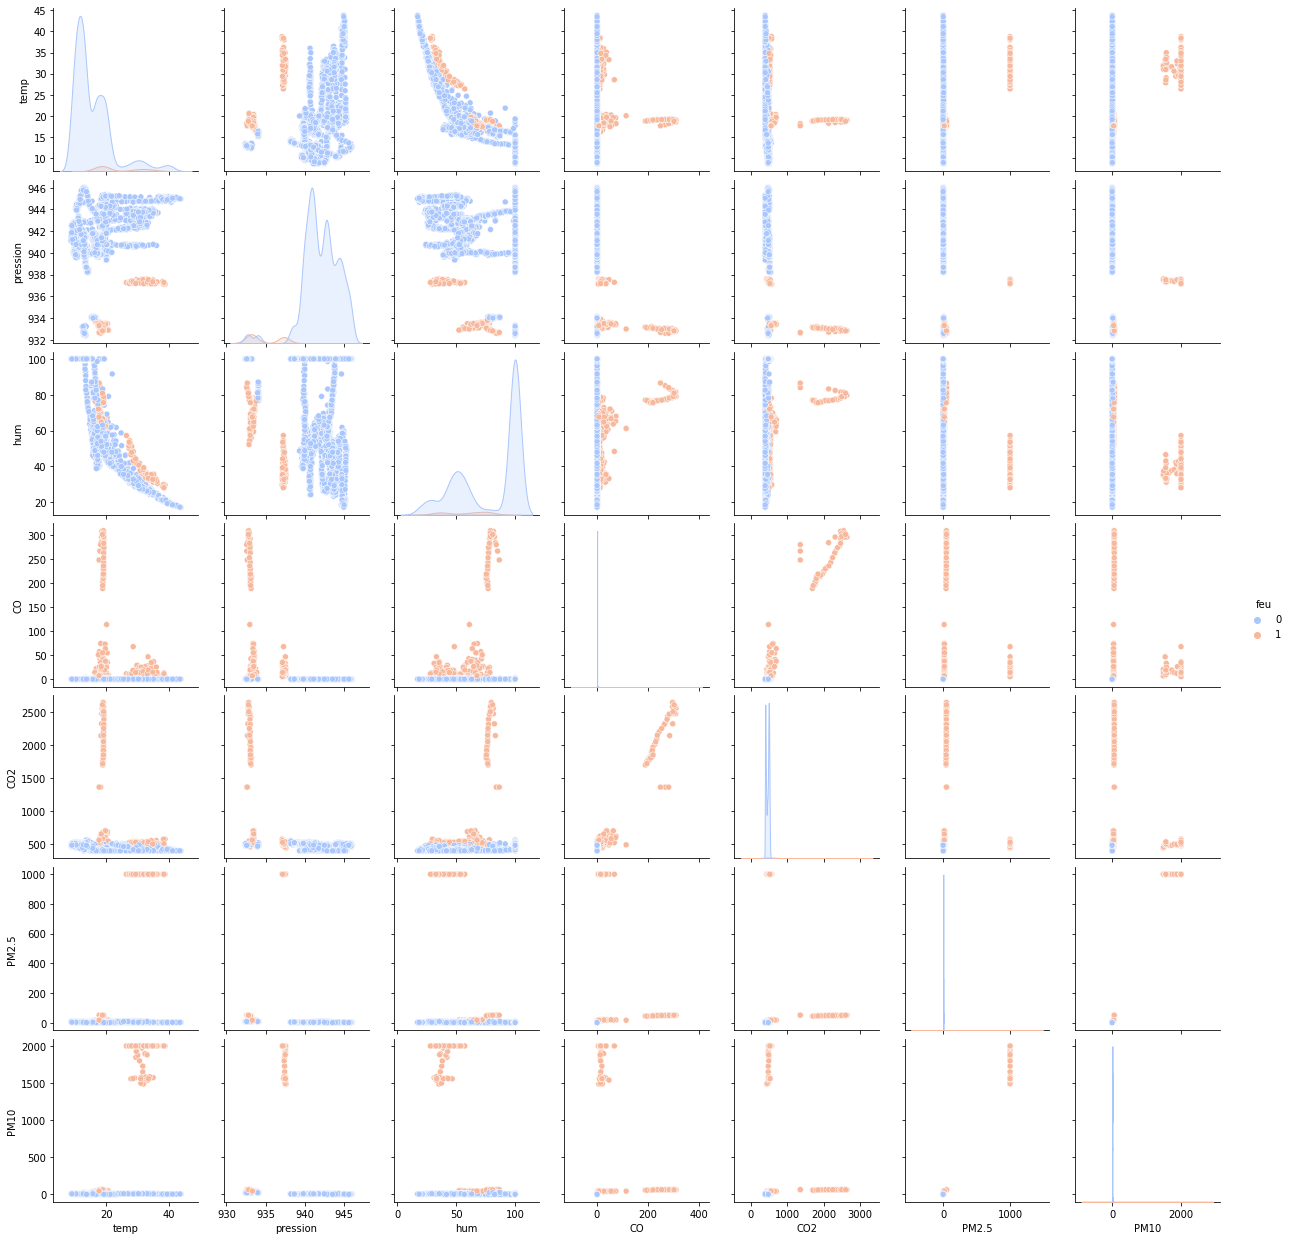

In [ ]:
sns.pairplot(data,hue="feu",palette='coolwarm')

### handeling the missing values

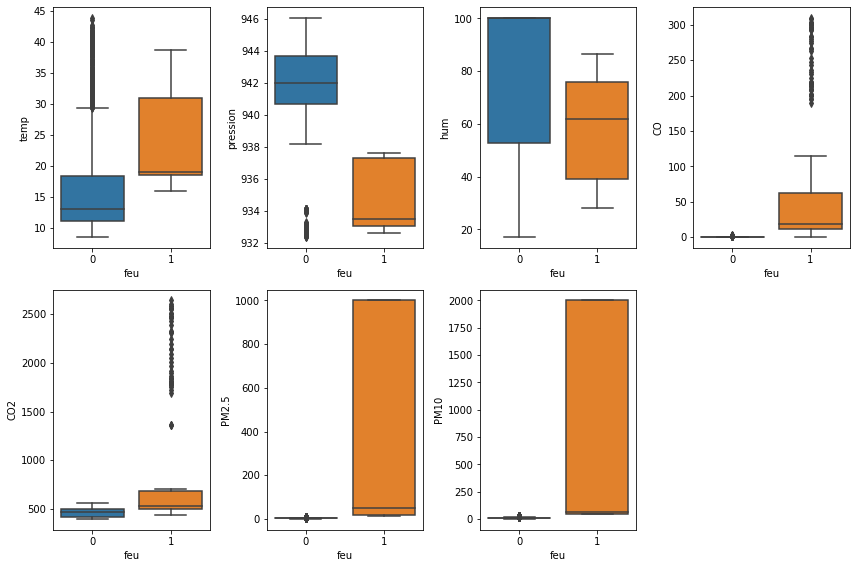

In [ ]:
### box plot of fire vs the other vars
plt.figure(figsize=(12,8))
for i,col in enumerate(X_col,1):
  plt.subplot(2,4,i)
  sns.boxplot(data=data,x='feu',y=col)
plt.tight_layout()
plt.show()

In [ ]:
#reducing the efect of the outlires
temp_outlires=data[(data['temp']>30)&(data['feu']==0)]
print("temp outlires: ",len(temp_outlires))
pression_outlires=data[(data['pression']<938)&(data['feu']==0)]
print("pression outlires: ",len(pression_outlires))
CO_outlires=data[(data['CO']>120)&(data['feu']==1)]
print("CO outlires: ",len(CO_outlires))
CO2_outlires=data[(data['CO2']>700)&(data['feu']==1)]
print("CO2 outlires: ",len(CO2_outlires))


temp outlires:  304
pression outlires:  140
CO outlires:  48
CO2 outlires:  50


In [ ]:
data[data["feu"]==1].describe().T

,count,mean,std,min,25%,50%,75%,max
temp,210.0,23.788381,6.878309,15.960000,18.542500,19.130000,30.942500,38.780000
pression,210.0,934.827117,2.043486,932.600578,933.083548,933.492029,937.284999,937.608261
hum,210.0,58.214054,17.464294,28.084189,39.255319,61.815608,75.806150,86.549213
CO,210.0,71.991905,100.070604,0.500000,11.600000,18.800000,62.300000,309.100000
CO2,210.0,886.153972,685.191758,438.846817,501.864126,528.318753,684.844127,2642.306557
PM2.5,210.0,407.987143,475.035849,13.700000,18.200000,48.200000,999.900000,999.900000
PM10,210.0,766.775714,903.512169,42.300000,45.900000,62.900000,1999.900000,1999.900000
feu,210.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Features selection with statistic analysis

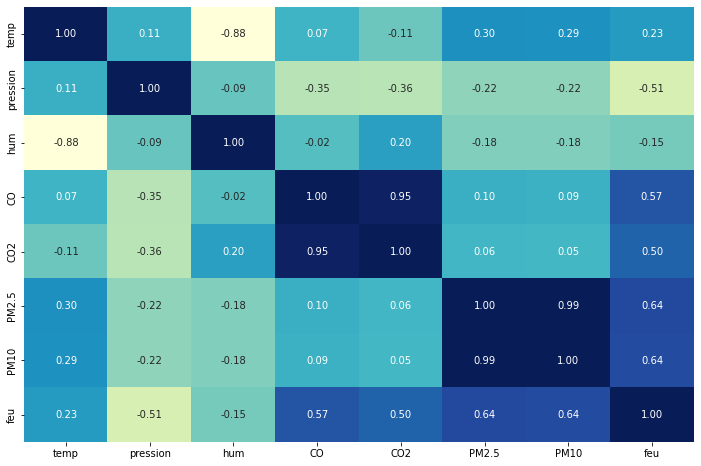

In [ ]:
X,y=data[X_col],data['feu']
plt.figure(figsize=(12,8))
sns.heatmap(data=data.corr(),annot=True,cmap='YlGnBu',fmt=".2f",cbar=False)
plt.show()

In [ ]:
### we observe that the CO & CO2 so we could delete one 'CO2'
data1=data.drop(['CO2'],axis=1)

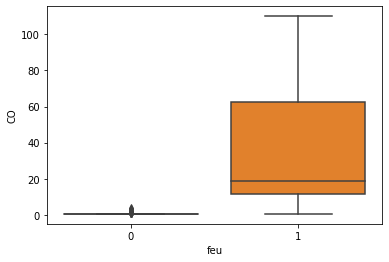

In [ ]:
data1['CO']=data1['CO'].apply(lambda x:110 if x>110 else x)
sns.boxplot(data=data1,x="feu",y='CO')

### Over_sampling with ADSYN for the data 

In [ ]:
X1=data1.drop(["feu"],axis=1)

In [ ]:
from collections import Counter
### we sould balance the data because we have much 0 than 1
ros=ADASYN(n_neighbors=5,sampling_strategy='auto',random_state=123,n_jobs=-1)
X_train,X_test,y_train,y_test=train_test_split(X1,y,test_size=0.3,random_state=123)
print("the tarin data shape before over_sampling: ", Counter(y_train))
### standrized the data
ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)
X_ros,y_ros=ros.fit_resample(X_train,y_train)
print("the tarin data shape after over_sampling: ", Counter(y_ros))

the tarin data shape before over_sampling:  Counter({0: 3717, 1: 152})
the tarin data shape after over_sampling:  Counter({0: 3717, 1: 3717})


In [ ]:
### define the plot function
def plot_val_curve(train_scores, val_scores, param_range, plt_title):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(14,6))
    
    plt.title(plt_title)
    plt.xlabel("$C-Regularization parameter$")
    plt.ylabel("Accuracy")
    
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    
    plt.semilogx(param_range, val_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    
    plt.fill_between(param_range, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")

def plot_learning_curve(X,y,clf_estimator, cv_estimator, scorer, xlabel=''):
    train_x_axis, train_scores, test_scores =learning_curve(estimator=clf_estimator,
                                                           X=X,
                                                           y=y,
                                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                                           cv=cv_estimator,
                                                           scoring=scorer,
                                                           exploit_incremental_learning=False,
                                                           n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()
    

def plot_confusion_matrix(cm, class_names, title_text='Confusion Matrix', normalize=False):
    plt.figure(figsize=(10,5))
    acc = cm.diagonal().sum()/cm.sum()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names,
               annot_kws={"size":15})
    plt.title(title_text+' Accuracy = {:.4f}'.format(acc), fontsize=20)
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual Class', fontsize=16)
    plt.tick_params(labelsize=14)

### Model selection and cross validation

In [ ]:
#use cross-validation strategy to select the best model
cross=StratifiedShuffleSplit(n_splits=10,random_state=763476)


## Train with XGBoost classifier 

### L2 Regularisation

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished


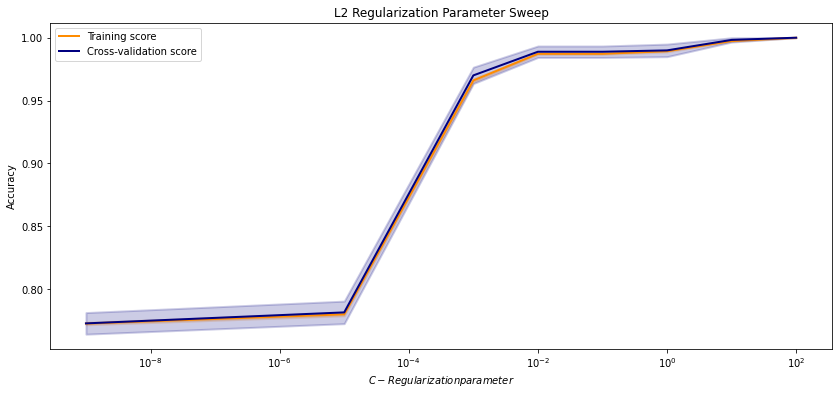

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_LR_L2 = LogisticRegression(penalty='l2', solver='liblinear',
                            random_state=178926, n_jobs=-1, max_iter=1000)
param_C_range = [1e-9, 1e-5, 1e-3, 1e-2, 1e-1, 1.0,10,100]
train_scores, val_scores = validation_curve(estimator=clf_LR_L2, 
                                            X=X_ros, 
                                            y=y_ros, 
                                            param_name='C', 
                                            param_range=param_C_range,
                                            cv=cross,
                                            n_jobs=-1,
                                            verbose=1,
                                            scoring='accuracy')

# Average precision corresponds to the area under the precision recall curve

plot_val_curve(train_scores, val_scores, param_C_range, plt_title='L2 Regularization Parameter Sweep')
plt.xscale('log')
plt.show()

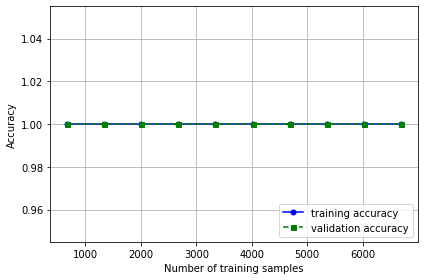

In [ ]:
XGB1=xgb(max_depth=5, learning_rate=0.05, n_estimators=1000, verbosity=1, silent=None, objective='binary:logistic', 
           booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0.1,
           reg_lambda=0.1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)
plot_learning_curve(X_ros, y_ros, XGB1, cross,'accuracy',xlabel='Number of training samples')

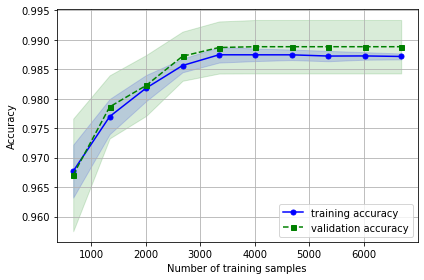

In [ ]:
clf_LR = LogisticRegression(penalty='l2', C=0.01, solver='liblinear',
                            random_state=178926, n_jobs=-1, max_iter=1000)

plot_learning_curve(X_ros, y_ros, clf_LR, cross,'accuracy',xlabel='Number of training samples')

### validate the data for Logistic regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_log

Cross-validation fold:  1
Cross-validation fold:  2
Cross-validation fold:  3
Cross-validation fold:  4
Cross-validation fold:  5
Cross-validation fold:  6
Cross-validation fold:  7
Cross-validation fold:  8
Cross-validation fold:  9
Cross-validation fold:  10

CV accuracy: 0.989 +/- 0.005

CV Recall: 1.000 +/- 0.000

CV F1_Score: 0.989 +/- 0.004

CV LogLoss: 0.385 +/- 0.157

CV AUPRC: 0.965 +/- 0.018


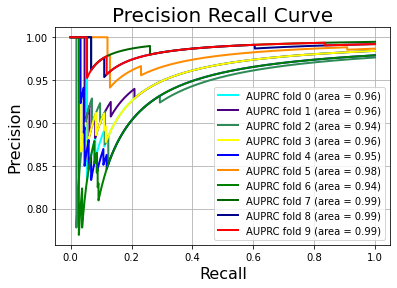

In [ ]:
clf_LR_metrics = list()

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange',
                'green', 'darkgreen','darkblue', 'red', 'magenta'])
lw = 2

i = 0

for (train_idx, val_idx), color in zip(cross.split(X_ros, y_ros), colors):
    X_train, y_train = X_ros[train_idx], y_ros[train_idx]
    X_val, y_val = X_ros[val_idx], y_ros[val_idx]
    n_classes = np.unique(y_train) #Get total classes 
    
    #Define and fit a logistic regression classifier
    #clf_LR = LogisticRegression(penalty='l2', C=0.01, solver='liblinear',
                              # random_state=178926, n_jobs=-1, max_iter=1000)
    clf_LR.fit(X_train, y_train)
    
    #Predict class label and probability for the validation data set
    y_pred = clf_LR.predict(X_val)
    y_prob = clf_LR.predict_proba(X_val)
    
    #Compute classification metrics
    acc = mt.accuracy_score(y_val, y_pred)
    recall = mt.recall_score(y_val, y_pred)
    f1 = mt.f1_score(y_val, y_pred)
    logloss = mt.log_loss(y_val, y_pred)
    
    #Compute precision, recall and AUPRC for different levels of thresholds
    precisions, recalls, thresholds = mt.precision_recall_curve(y_val.ravel(), y_prob[:, 1].ravel(), pos_label=1)
    prc_auc = mt.average_precision_score(y_val, y_prob[:,1], average='weighted')
    plt.plot(recalls, precisions, lw=lw, color=color,
             label='AUPRC fold %d (area = %0.2f)' % (i, prc_auc))
    
    i +=1 #Counter for validation fold
    print("Cross-validation fold: ",i)
    
    clf_LR_metrics.append([acc, f1, recall, logloss, prc_auc])


#Summary of classification performance
clf_LR_metrics = pd.DataFrame(clf_LR_metrics, columns=['Accuracy','F1_Score', 'Recall', 'LogLoss','AUPRC'])

plt.legend(loc='best')
plt.grid()
plt.title('Precision Recall Curve', fontsize=20)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.Accuracy), np.std(clf_LR_metrics.Accuracy)))
print('\nCV Recall: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.Recall), np.std(clf_LR_metrics.Recall)))
print('\nCV F1_Score: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.F1_Score), np.std(clf_LR_metrics.F1_Score)))
print('\nCV LogLoss: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.LogLoss), np.std(clf_LR_metrics.LogLoss)))
print('\nCV AUPRC: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.AUPRC), np.std(clf_LR_metrics.AUPRC)))

### the test step for logistic Reg with AUPRC

Test accuracy: 0.972

Test Precision: 0.558

Test Recall: 1.000

Test LogLoss: 0.958

Test AUPRC: 0.988


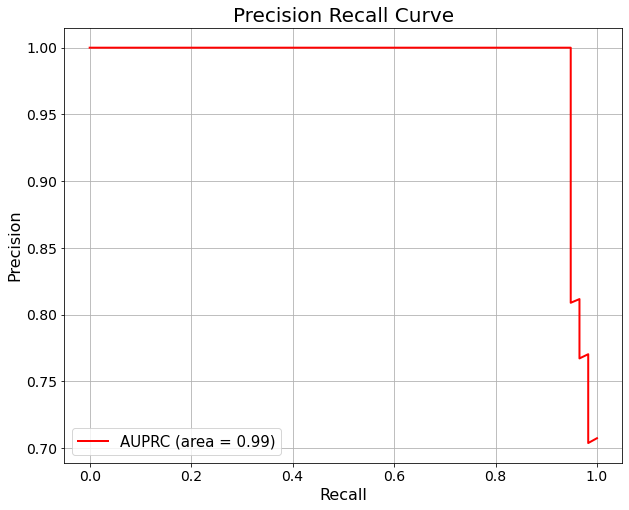

In [ ]:
#Predict class label and probability for the validation data set
y_pred = clf_LR.predict(X_test)
y_prob = clf_LR.predict_proba(X_test)

    
#Compute classification metrics
acc = mt.accuracy_score(y_test, y_pred)
precision = mt.precision_score(y_test, y_pred)
recall = mt.recall_score(y_test, y_pred)
# f1 = mt.f1_score(y_test, y_pred)
logloss = mt.log_loss(y_test, y_pred)
    
#Compute precision, recall and AUPRC for different levels of thresholds
precisions, recalls, thresholds = mt.precision_recall_curve(y_test.ravel(), y_prob[:, 1].ravel(), pos_label=1)
prc_auc = mt.average_precision_score(y_test, y_prob[:,1], average='weighted')

plt.figure(figsize=(10,8))
plt.plot(recalls, precisions, lw=lw, color=color,
         label='AUPRC (area = %0.2f)' % prc_auc)
plt.legend(loc='best', fontsize=15)
plt.grid()
plt.title('Precision Recall Curve', fontsize=20)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.tick_params(labelsize=14)

print('Test accuracy: %.3f' % (acc))
print('\nTest Precision: %.3f' % (precision))
print('\nTest Recall: %.3f' % (recall))
print('\nTest LogLoss: %.3f' % (logloss))
print('\nTest AUPRC: %.3f' % (prc_auc))


###  using the confusing matrix



Confusion matrix, without normalization


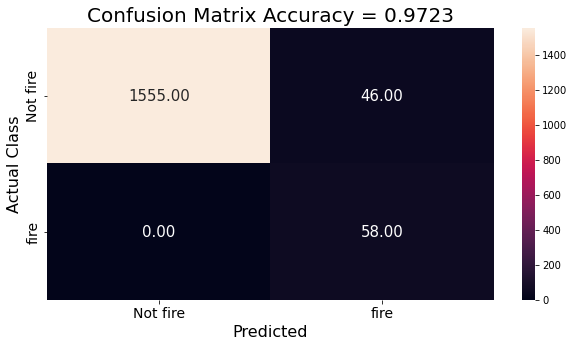

In [ ]:
class_names = ['Not fire', 'fire']
cm = mt.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)